<a href="https://colab.research.google.com/github/LingyiC/A-Cross-world-Happiness-Study-and-Website-Deploy/blob/master/scanpy/Copy_of_paga_paul15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PAGA for hematopoiesis in mouse [(Paul et al., 2015)](https://doi.org/10.1016/j.cell.2015.11.013)

Tracing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
!pip install scanpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.3 anndata==0.6.20 umap==0.3.8 numpy==1.16.3 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.1 statsmodels==0.9.0 


In [0]:
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures

In [4]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


In [5]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [0]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [7]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
    finished (0:00:00.58)


In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00.65)


In [26]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:283: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.43) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:20.91) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


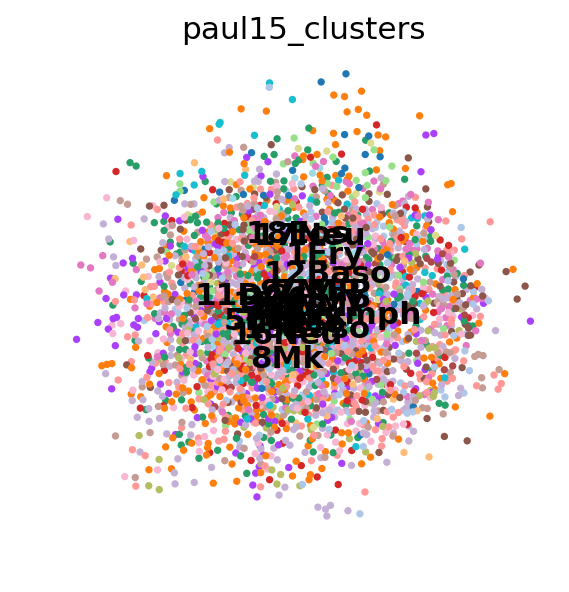

In [21]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This looks like a mess.

## Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It's very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. [Schiebinger et al. (2017)](https://doi.org/10.1101/191056) or [Tabaka et al. (2018)](https://doi.org/10.1101/512582). It's also related to the principles behind MAGIC [Dijk et al. (2018)](https://doi.org/10.1016/j.cell.2018.05.061).

<div class="alert alert-info">

**Note**
    
This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.
    
</div>  

In [0]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [0]:
sc.tl.draw_graph(adata)

In [0]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

In [0]:
sc.tl.louvain(adata, resolution=1.0)

Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [0]:
sc.tl.paga(adata, groups='louvain')

In [0]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

In [0]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [0]:
adata.obs['louvain'].cat.categories

In [0]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [0]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

Let's use the annotated clusters for PAGA.

In [0]:
sc.tl.paga(adata, groups='louvain_anno')

In [0]:
sc.pl.paga(adata, threshold=0.03)

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [0]:
sc.tl.draw_graph(adata, init_pos='paga')

Now we can see all marker genes also at single-cell resolution in a meaningful layout.

In [0]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Choose the colors of the clusters a bit more consistently.

In [0]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [0]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [0]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [0]:
adata.uns['louvain_anno_colors'] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

In [0]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [0]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [0]:
sc.tl.dpt(adata)

Select some of the marker gene names.

In [0]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [0]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

In [0]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [0]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [0]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [0]:
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change

In [0]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [0]:
!mkdir write

In [0]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()